In [1]:
# https://github.com/huggingface/peft/blob/main/examples/sequence_classification/prefix_tuning.ipynb

In [2]:
!pip install accelerate -U
!pip install transformers datasets evaluate accelerate peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
from google.colab import drive
import pandas as pd
import os
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PrefixTuningConfig
)

In [4]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Comp545_FinalProject/code')

from model.train import training_loop
from model.evaluate import evaluate_model
from utils.funcs import load_data, load_tokenizer_model, prepare_dataloader
from utils.plot import plot_confusion_matrix
from utils.test_cases import run_test_cases

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Mounted at /content/drive


## Train and evaluate on combine data

In [5]:
train_combine_data_path = "../data_PEFT/lab-manual-combine-train.xlsx"
test_combine_data_path = "../data_PEFT/lab-manual-combine-test.xlsx"

sentences_combine, labels_combine, sentences_test_combine, labels_test_combine = load_data(train_combine_data_path, test_combine_data_path)

In [6]:
language_model_to_use = 'roberta-large'
batch_size = 16

train_val_dataloader_combine = prepare_dataloader(language_model_to_use, sentences_combine, labels_combine, batch_size, device, return_train_dataloader=True)
test_dataloader_combine = prepare_dataloader(language_model_to_use, sentences_test_combine, labels_test_combine, batch_size, device, return_train_dataloader=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Size: 4568, Validation Size: 1141


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Size: 1428


In [7]:
peft_config = PrefixTuningConfig(task_type="SEQ_CLS", peft_type="PREFIX_TUNING", num_virtual_tokens=20)
peft_type = PeftType.PREFIX_TUNING

tokenizer, model = load_tokenizer_model(language_model_to_use, device)
model_prefix_tuning = get_peft_model(model, peft_config)
model_prefix_tuning.print_trainable_parameters()
# model_prefix_tuning

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,035,715 || all params: 357,398,534 || trainable%: 0.569592431512324


In [8]:
optimizer = AdamW(params=model.parameters(), lr=1e-4)
num_epochs = 20
num_training_steps = len(train_val_dataloader_combine['train']) * num_epochs

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_val_dataloader_combine['train']) * num_epochs),
    num_training_steps=num_training_steps,
)

In [9]:
accuracy_list, f1_list = training_loop(model_prefix_tuning, device, num_epochs, train_val_dataloader_combine, optimizer, lr_scheduler)

100%|██████████| 286/286 [06:50<00:00,  1.43s/it]


Epoch [1/20], Training loss: 1.1152


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Epoch [1/20], Validation accuracy:
{'accuracy': 0.48466257668711654}
Epoch [1/20], Validation f1:
{'f1': 0.3164325913907621}
---------------------------------------------------


100%|██████████| 286/286 [06:29<00:00,  1.36s/it]


Epoch [2/20], Training loss: 1.0949


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Epoch [2/20], Validation accuracy:
{'accuracy': 0.48466257668711654}
Epoch [2/20], Validation f1:
{'f1': 0.3164325913907621}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [3/20], Training loss: 1.2396


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Epoch [3/20], Validation accuracy:
{'accuracy': 0.5056967572304996}
Epoch [3/20], Validation f1:
{'f1': 0.4031529956169317}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [4/20], Training loss: 0.8797


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Epoch [4/20], Validation accuracy:
{'accuracy': 0.4864154250657318}
Epoch [4/20], Validation f1:
{'f1': 0.32028737036561944}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [5/20], Training loss: 0.8186


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Epoch [5/20], Validation accuracy:
{'accuracy': 0.4864154250657318}
Epoch [5/20], Validation f1:
{'f1': 0.32028737036561944}
---------------------------------------------------


100%|██████████| 286/286 [06:29<00:00,  1.36s/it]


Epoch [6/20], Training loss: 1.0951


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Epoch [6/20], Validation accuracy:
{'accuracy': 0.5074496056091148}
Epoch [6/20], Validation f1:
{'f1': 0.3879061212942289}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [7/20], Training loss: 0.6381


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Epoch [7/20], Validation accuracy:
{'accuracy': 0.5477651183172656}
Epoch [7/20], Validation f1:
{'f1': 0.5174700156984359}
---------------------------------------------------


100%|██████████| 286/286 [06:29<00:00,  1.36s/it]


Epoch [8/20], Training loss: 0.7290


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Epoch [8/20], Validation accuracy:
{'accuracy': 0.5144609991235758}
Epoch [8/20], Validation f1:
{'f1': 0.40340932625571896}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [9/20], Training loss: 0.5500


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Epoch [9/20], Validation accuracy:
{'accuracy': 0.5205959684487291}
Epoch [9/20], Validation f1:
{'f1': 0.4738214052824237}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [10/20], Training loss: 0.8190


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Epoch [10/20], Validation accuracy:
{'accuracy': 0.5346187554776511}
Epoch [10/20], Validation f1:
{'f1': 0.4440988103873868}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [11/20], Training loss: 0.9922


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Epoch [11/20], Validation accuracy:
{'accuracy': 0.5311130587204207}
Epoch [11/20], Validation f1:
{'f1': 0.4872094141162023}
---------------------------------------------------


100%|██████████| 286/286 [06:29<00:00,  1.36s/it]


Epoch [12/20], Training loss: 0.9219


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Epoch [12/20], Validation accuracy:
{'accuracy': 0.5416301489921121}
Epoch [12/20], Validation f1:
{'f1': 0.4795074380818167}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [13/20], Training loss: 0.9484


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Epoch [13/20], Validation accuracy:
{'accuracy': 0.5556529360210342}
Epoch [13/20], Validation f1:
{'f1': 0.49559733165678443}
---------------------------------------------------


100%|██████████| 286/286 [06:29<00:00,  1.36s/it]


Epoch [14/20], Training loss: 0.9256


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Epoch [14/20], Validation accuracy:
{'accuracy': 0.5346187554776511}
Epoch [14/20], Validation f1:
{'f1': 0.5035052284531064}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [15/20], Training loss: 1.0323


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Epoch [15/20], Validation accuracy:
{'accuracy': 0.5346187554776511}
Epoch [15/20], Validation f1:
{'f1': 0.47699135030403716}
---------------------------------------------------


100%|██████████| 286/286 [06:29<00:00,  1.36s/it]


Epoch [16/20], Training loss: 0.7246


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Epoch [16/20], Validation accuracy:
{'accuracy': 0.588957055214724}
Epoch [16/20], Validation f1:
{'f1': 0.5700814614174815}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [17/20], Training loss: 0.7651


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Epoch [17/20], Validation accuracy:
{'accuracy': 0.5705521472392638}
Epoch [17/20], Validation f1:
{'f1': 0.5417241166713267}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [18/20], Training loss: 0.7180


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Epoch [18/20], Validation accuracy:
{'accuracy': 0.5784399649430324}
Epoch [18/20], Validation f1:
{'f1': 0.5565080607502967}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [19/20], Training loss: 0.7406


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Epoch [19/20], Validation accuracy:
{'accuracy': 0.5872042068361086}
Epoch [19/20], Validation f1:
{'f1': 0.5678922491333398}
---------------------------------------------------


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [20/20], Training loss: 0.6805


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]

Epoch [20/20], Validation accuracy:
{'accuracy': 0.588957055214724}
Epoch [20/20], Validation f1:
{'f1': 0.5668097994682296}
---------------------------------------------------


In [10]:
accuracy_list

[{'accuracy': 0.48466257668711654},
 {'accuracy': 0.48466257668711654},
 {'accuracy': 0.5056967572304996},
 {'accuracy': 0.4864154250657318},
 {'accuracy': 0.4864154250657318},
 {'accuracy': 0.5074496056091148},
 {'accuracy': 0.5477651183172656},
 {'accuracy': 0.5144609991235758},
 {'accuracy': 0.5205959684487291},
 {'accuracy': 0.5346187554776511},
 {'accuracy': 0.5311130587204207},
 {'accuracy': 0.5416301489921121},
 {'accuracy': 0.5556529360210342},
 {'accuracy': 0.5346187554776511},
 {'accuracy': 0.5346187554776511},
 {'accuracy': 0.588957055214724},
 {'accuracy': 0.5705521472392638},
 {'accuracy': 0.5784399649430324},
 {'accuracy': 0.5872042068361086},
 {'accuracy': 0.588957055214724}]

In [11]:
f1_list

[{'f1': 0.3164325913907621},
 {'f1': 0.3164325913907621},
 {'f1': 0.4031529956169317},
 {'f1': 0.32028737036561944},
 {'f1': 0.32028737036561944},
 {'f1': 0.3879061212942289},
 {'f1': 0.5174700156984359},
 {'f1': 0.40340932625571896},
 {'f1': 0.4738214052824237},
 {'f1': 0.4440988103873868},
 {'f1': 0.4872094141162023},
 {'f1': 0.4795074380818167},
 {'f1': 0.49559733165678443},
 {'f1': 0.5035052284531064},
 {'f1': 0.47699135030403716},
 {'f1': 0.5700814614174815},
 {'f1': 0.5417241166713267},
 {'f1': 0.5565080607502967},
 {'f1': 0.5678922491333398},
 {'f1': 0.5668097994682296}]

In [12]:
accuracy, f1, predictions_list, labels_list = evaluate_model(model_prefix_tuning, test_dataloader_combine, device)

Test accuracy:  {'accuracy': 0.572829131652661}
Test f1:  {'f1': 0.5504787691801749}


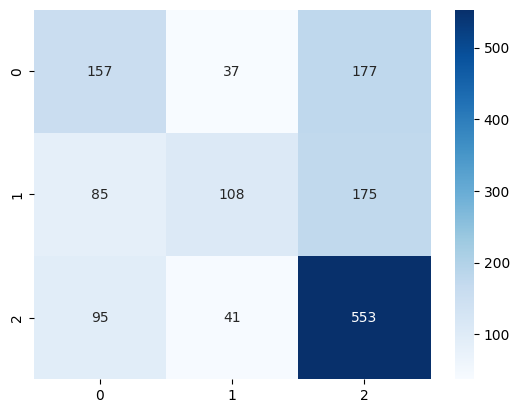

In [13]:
plot_confusion_matrix(labels_list, predictions_list)

In [14]:
# test some cases
prefix_tuning_model_combinedata_name = 'prefix_tuning-model-combinedata'
prefix_tuning_tokenizer_combinedata_name = 'prefix_tuning-tokenizer-combinedata'

# Save model
tokenizer.save_pretrained(prefix_tuning_tokenizer_combinedata_name)
model_prefix_tuning.save_pretrained(prefix_tuning_model_combinedata_name)

run_test_cases(prefix_tuning_model_combinedata_name, prefix_tuning_tokenizer_combinedata_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1
The Committee anticipates that ongoing increases in the target range for the federal funds rate will be appropriate.
correct answer: Hawkish
predicted classification:  Neutral
Example 2
In light of the softer economic outlook, we will maintain the current federal funds rate.
correct answer: Dovish
predicted classification:  Neutral
Example 3
Economic activity has been rising at a strong rate.
correct answer: Neutral
predicted classification:  Hawkish
Example 4
Considering the elevated inflation pressures, we may consider further rate hikes.
correct answer: Hawkish
predicted classification:  Hawkish
Example 5
The labor market continues to strengthen, but inflation remains below our 2 percent longer-run objective.
correct answer: Dovish
predicted classification:  Dovish


## Train and evaluate on split combine data

In [15]:
train_split_combine_data_path = "../data_PEFT/lab-manual-split-combine-train.xlsx"
test_split_combine_data_path = "../data_PEFT/lab-manual-split-combine-test.xlsx"

sentences_split_combine, labels_split_combine, sentences_test_split_combine, labels_test_split_combine = load_data(train_split_combine_data_path,
                                                                                                                   test_split_combine_data_path)

In [16]:
language_model_to_use = 'roberta-large'
batch_size = 16

train_val_dataloader_split_combine = prepare_dataloader(language_model_to_use,
                                                        sentences_split_combine,
                                                        labels_split_combine,
                                                        batch_size,
                                                        device,
                                                        return_train_dataloader=True)
test_dataloader_split_combine = prepare_dataloader(language_model_to_use,
                                                   sentences_test_split_combine,
                                                   labels_test_split_combine,
                                                   batch_size,
                                                   device,
                                                   return_train_dataloader=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Size: 4762, Validation Size: 1190


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Size: 1488


In [17]:
peft_config = PrefixTuningConfig(task_type="SEQ_CLS", peft_type="PREFIX_TUNING", num_virtual_tokens=20)
peft_type = PeftType.PREFIX_TUNING

tokenizer, model = load_tokenizer_model(language_model_to_use, device)
model_prefix_tuning = get_peft_model(model, peft_config)
model_prefix_tuning.print_trainable_parameters()
# model_prefix_tuning

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,035,715 || all params: 357,398,534 || trainable%: 0.569592431512324


In [18]:
optimizer = AdamW(params=model.parameters(), lr=1e-4)
num_epochs = 20
num_training_steps = len(train_val_dataloader_split_combine['train']) * num_epochs

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_val_dataloader_split_combine['train']) * num_epochs),
    num_training_steps=num_training_steps,
)

In [19]:
accuracy_list_splitdata, f1_list_splitdata = training_loop(model_prefix_tuning,
                                                           device,
                                                           num_epochs,
                                                           train_val_dataloader_split_combine,
                                                           optimizer,
                                                           lr_scheduler)

100%|██████████| 298/298 [07:13<00:00,  1.45s/it]


Epoch [1/20], Training loss: 1.0782


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [1/20], Validation accuracy:
{'accuracy': 0.48487394957983193}
Epoch [1/20], Validation f1:
{'f1': 0.3166635754471568}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [2/20], Training loss: 1.0682


100%|██████████| 75/75 [00:50<00:00,  1.49it/s]


Epoch [2/20], Validation accuracy:
{'accuracy': 0.48487394957983193}
Epoch [2/20], Validation f1:
{'f1': 0.3166635754471568}
---------------------------------------------------


100%|██████████| 298/298 [06:45<00:00,  1.36s/it]


Epoch [3/20], Training loss: 0.8761


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [3/20], Validation accuracy:
{'accuracy': 0.48403361344537815}
Epoch [3/20], Validation f1:
{'f1': 0.31683198520474554}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [4/20], Training loss: 0.9532


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [4/20], Validation accuracy:
{'accuracy': 0.4857142857142857}
Epoch [4/20], Validation f1:
{'f1': 0.32032062257366056}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [5/20], Training loss: 0.9219


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [5/20], Validation accuracy:
{'accuracy': 0.5042016806722689}
Epoch [5/20], Validation f1:
{'f1': 0.3627599172239379}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [6/20], Training loss: 1.2373


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [6/20], Validation accuracy:
{'accuracy': 0.5294117647058824}
Epoch [6/20], Validation f1:
{'f1': 0.42504991896781963}
---------------------------------------------------


100%|██████████| 298/298 [06:45<00:00,  1.36s/it]


Epoch [7/20], Training loss: 1.1824


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [7/20], Validation accuracy:
{'accuracy': 0.5285714285714286}
Epoch [7/20], Validation f1:
{'f1': 0.44801220134002034}
---------------------------------------------------


100%|██████████| 298/298 [06:45<00:00,  1.36s/it]


Epoch [8/20], Training loss: 0.7298


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [8/20], Validation accuracy:
{'accuracy': 0.5495798319327732}
Epoch [8/20], Validation f1:
{'f1': 0.48307447407097315}
---------------------------------------------------


100%|██████████| 298/298 [06:45<00:00,  1.36s/it]


Epoch [9/20], Training loss: 0.7416


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [9/20], Validation accuracy:
{'accuracy': 0.5277310924369748}
Epoch [9/20], Validation f1:
{'f1': 0.44449090796703006}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [10/20], Training loss: 1.0016


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [10/20], Validation accuracy:
{'accuracy': 0.5605042016806723}
Epoch [10/20], Validation f1:
{'f1': 0.5045400979827778}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [11/20], Training loss: 0.8667


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [11/20], Validation accuracy:
{'accuracy': 0.5394957983193277}
Epoch [11/20], Validation f1:
{'f1': 0.4910162139306336}
---------------------------------------------------


100%|██████████| 298/298 [06:45<00:00,  1.36s/it]


Epoch [12/20], Training loss: 0.7524


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [12/20], Validation accuracy:
{'accuracy': 0.5546218487394958}
Epoch [12/20], Validation f1:
{'f1': 0.5064284836686208}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [13/20], Training loss: 0.8274


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [13/20], Validation accuracy:
{'accuracy': 0.5647058823529412}
Epoch [13/20], Validation f1:
{'f1': 0.5278013233667213}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [14/20], Training loss: 0.8762


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [14/20], Validation accuracy:
{'accuracy': 0.5521008403361345}
Epoch [14/20], Validation f1:
{'f1': 0.4910099037323814}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [15/20], Training loss: 0.9198


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [15/20], Validation accuracy:
{'accuracy': 0.5647058823529412}
Epoch [15/20], Validation f1:
{'f1': 0.5287918087415232}
---------------------------------------------------


100%|██████████| 298/298 [06:45<00:00,  1.36s/it]


Epoch [16/20], Training loss: 0.7007


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [16/20], Validation accuracy:
{'accuracy': 0.5705882352941176}
Epoch [16/20], Validation f1:
{'f1': 0.5301081473763668}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [17/20], Training loss: 0.9705


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [17/20], Validation accuracy:
{'accuracy': 0.5487394957983194}
Epoch [17/20], Validation f1:
{'f1': 0.4866103044874596}
---------------------------------------------------


100%|██████████| 298/298 [06:45<00:00,  1.36s/it]


Epoch [18/20], Training loss: 0.8437


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [18/20], Validation accuracy:
{'accuracy': 0.5714285714285714}
Epoch [18/20], Validation f1:
{'f1': 0.5511524973625813}
---------------------------------------------------


100%|██████████| 298/298 [06:45<00:00,  1.36s/it]


Epoch [19/20], Training loss: 1.0257


100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


Epoch [19/20], Validation accuracy:
{'accuracy': 0.573109243697479}
Epoch [19/20], Validation f1:
{'f1': 0.5528761676081861}
---------------------------------------------------


100%|██████████| 298/298 [06:44<00:00,  1.36s/it]


Epoch [20/20], Training loss: 0.6893


100%|██████████| 75/75 [00:50<00:00,  1.49it/s]

Epoch [20/20], Validation accuracy:
{'accuracy': 0.5714285714285714}
Epoch [20/20], Validation f1:
{'f1': 0.5435613850240343}
---------------------------------------------------


In [20]:
accuracy_list_splitdata

[{'accuracy': 0.48487394957983193},
 {'accuracy': 0.48487394957983193},
 {'accuracy': 0.48403361344537815},
 {'accuracy': 0.4857142857142857},
 {'accuracy': 0.5042016806722689},
 {'accuracy': 0.5294117647058824},
 {'accuracy': 0.5285714285714286},
 {'accuracy': 0.5495798319327732},
 {'accuracy': 0.5277310924369748},
 {'accuracy': 0.5605042016806723},
 {'accuracy': 0.5394957983193277},
 {'accuracy': 0.5546218487394958},
 {'accuracy': 0.5647058823529412},
 {'accuracy': 0.5521008403361345},
 {'accuracy': 0.5647058823529412},
 {'accuracy': 0.5705882352941176},
 {'accuracy': 0.5487394957983194},
 {'accuracy': 0.5714285714285714},
 {'accuracy': 0.573109243697479},
 {'accuracy': 0.5714285714285714}]

In [21]:
f1_list_splitdata

[{'f1': 0.3166635754471568},
 {'f1': 0.3166635754471568},
 {'f1': 0.31683198520474554},
 {'f1': 0.32032062257366056},
 {'f1': 0.3627599172239379},
 {'f1': 0.42504991896781963},
 {'f1': 0.44801220134002034},
 {'f1': 0.48307447407097315},
 {'f1': 0.44449090796703006},
 {'f1': 0.5045400979827778},
 {'f1': 0.4910162139306336},
 {'f1': 0.5064284836686208},
 {'f1': 0.5278013233667213},
 {'f1': 0.4910099037323814},
 {'f1': 0.5287918087415232},
 {'f1': 0.5301081473763668},
 {'f1': 0.4866103044874596},
 {'f1': 0.5511524973625813},
 {'f1': 0.5528761676081861},
 {'f1': 0.5435613850240343}]

In [22]:
accuracy_splitdata, f1_splitdata, predictions_list_splitdata, labels_list_splitdata = evaluate_model(model_prefix_tuning,
                                                                                                     test_dataloader_split_combine,
                                                                                                     device)

Test accuracy:  {'accuracy': 0.5853494623655914}
Test f1:  {'f1': 0.5625797740568919}


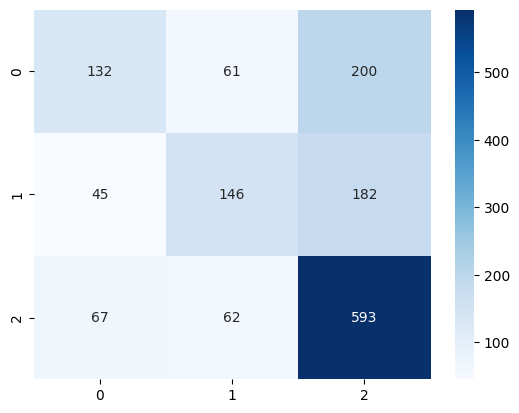

In [23]:
plot_confusion_matrix(labels_list_splitdata, predictions_list_splitdata)

In [24]:
# test some cases
prefix_tuning_model_splitdata_name = 'prefix_tuning-model-splitdata'
prefix_tuning_tokenizer_splitdata_name = 'prefix_tuning-tokenizer-splitdata'

# Save model
tokenizer.save_pretrained(prefix_tuning_tokenizer_splitdata_name)
model_prefix_tuning.save_pretrained(prefix_tuning_model_splitdata_name)

run_test_cases(prefix_tuning_model_splitdata_name, prefix_tuning_tokenizer_splitdata_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1
The Committee anticipates that ongoing increases in the target range for the federal funds rate will be appropriate.
correct answer: Hawkish
predicted classification:  Neutral
Example 2
In light of the softer economic outlook, we will maintain the current federal funds rate.
correct answer: Dovish
predicted classification:  Dovish
Example 3
Economic activity has been rising at a strong rate.
correct answer: Neutral
predicted classification:  Neutral
Example 4
Considering the elevated inflation pressures, we may consider further rate hikes.
correct answer: Hawkish
predicted classification:  Hawkish
Example 5
The labor market continues to strengthen, but inflation remains below our 2 percent longer-run objective.
correct answer: Dovish
predicted classification:  Hawkish
